In [1]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import libconf
# from scipy.integrate import simps
from scipy.integrate import simpson
from astropy.io import fits

import camb
from camb import model, initialpower


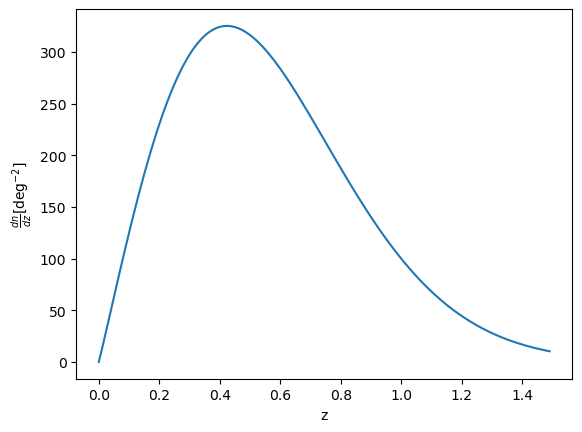

In [2]:
dirname_out = 'mapas'
os.system(f'mkdir -p {dirname_out}')

# Redshift distribution

def dndz_des_alonso(zi, amp=22.357, alpha=1.044, z0=0.568, beta=1.742):
    """
    in deg⁻2
    """
    return amp*(zi/z0)**alpha*np.exp(-(zi/z0)**beta)*3600/100


zs = np.arange(0.0, 1.5, 0.01)
nz = dndz_des_alonso(zs)

bz = np.ones_like(zs)

np.savetxt(f'{dirname_out}/dndz.txt', np.transpose([zs, nz]))
np.savetxt(f'{dirname_out}/bias.txt', np.transpose([zs, bz]))

plt.plot(zs, nz)
plt.ylabel(r'$\frac{dn}{dz}[{\rm deg^{-2}}]$')
plt.xlabel('z')
plt.show()



In [3]:
from scipy.integrate import quad
norm=quad(lambda x: dndz_des_alonso(x),0,1)[0]
print(norm)

220.44658511762938


In [4]:


# set cosmology

###Set cosmology
h0=0.6774
H0=h0*100
Om=0.31
OL=1-Om
Ob=0.05
Ocdm=Om-Ob
As = 2.142e-9
ns = 0.967

def get_pk(z_in):
    """Returns k, Pk, f and sigma8
    in h units"""
    #Set up the fiducial cosmology
    pars = camb.CAMBparams()
    #Set cosmology
    pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2,omk=0,mnu=0)
    pars.set_dark_energy() #LCDM (default)
    pars.InitPower.set_params(ns=ns, r=0, As=As)
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 500)
    
    s8 = results.get_sigma8()
    f = results.get_fsigma8()/s8
    
    return kh, pk[0], f[0], s8[0]

def Pk_noh(zc,kk):
    """Returns Pk, its derivative and 
    f and sigma8"""
    kh, pk, f, s8 = get_pk(zc)
    Pkz=splrep(kh*h0, pk[0]/h0**3)
    return splev(kk,Pkz),splev(kk,Pkz,der=1), f, s8

k_h, pk_h, f, s8 = get_pk(0)

#print(k_h, pk_h, f, s8)

csm = {'omega_M': Om,
       'omega_B': Ob,
       'omega_L': OL,
       'h': h0,
       'w': -1.0,
       'ns': ns,
       'sigma_8': s8}

cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')

np.savetxt(f'{dirname_out}/pk.txt', np.transpose([k_h, pk_h]))

In [6]:
# CoLoRe config

#n_grid = 256
n_grid = 512
#n_grid = 1024


config = {}
config['global'] = {'prefix_out': dirname_out + '/colore',
                    'output_format': 'FITS',
                    'output_density': True,
                    'pk_filename': f'{dirname_out}/pk.txt',
                    'z_min': 0.001,
                    'z_max': 1.5,
                    'seed': 1000,
                    'write_pred': False,
                    'just_write_pred': False}
config['field_par'] = {'r_smooth': 1.,
                       'smooth_potential': True,
                       'n_grid': n_grid,
                       'dens_type': 1,
                       'lpt_buffer_fraction': 0.6,
                       'lpt_interp_type': 1,
                       'output_lpt': 0}
config['cosmo_par'] = csm
config['srcs1'] = {'nz_filename': f'{dirname_out}/dndz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'include_lensing': True,
                   'store_skewers': False}
with open(f'{dirname_out}/params.cfg', 'w') as configfile:
    libconf.dump(config, configfile)

os.system(f'../CoLoRe/CoLoRe {dirname_out}/params.cfg > {dirname_out}/log.txt')
f = open(f'{dirname_out}/log.txt', 'r')
print(f.read())
f.close()


MPI task 0, OMP thread count starts at 0
 MPIThreadsOK = 1

|-------------------------------------------------|
|                      CoLoRe                     |
|-------------------------------------------------|

The cosmological model is:
 O_M=0.310 O_L=0.690 O_K=0.000
 O_B=0.050 w=-1.000 h=0.677
 Flat universe, standard cosmological constant

 Time of equality: a_eq=0.76610
 Particle horizon: chi_H(0)=9.777E+03 Mpc/h
 Present growth factor: D_0=0.785

Reading P_k from file: mapas/pk.txt
  Original sigma8=0.825871
  Sigma_Gauss should be 0.768860
Node 0 will allocate 4.394 GB [1.509 GB (Gaussian), 2.409 GB (1LPT), 0.475 GB (srcs)]

Run parameters: 
  0.001 < z < 1.000
  2.997 < r/(Mpc/h) < 2299.117
  L_box = 4616.195 Mpc/h, N_grid = 512 
  Scales resolved: 1.361E-03 < k < 3.478E-01 h/Mpc
  Fourier-space resolution: dk = 1.361E-03 h/Mpc
  Real-space resolution: dx = 9.016E+00 Mpc/h
  Density field pre-smoothed on scales: x_s = 1.000E+00 Mpc/h
  1 galaxy populations
  Will include l

9159914


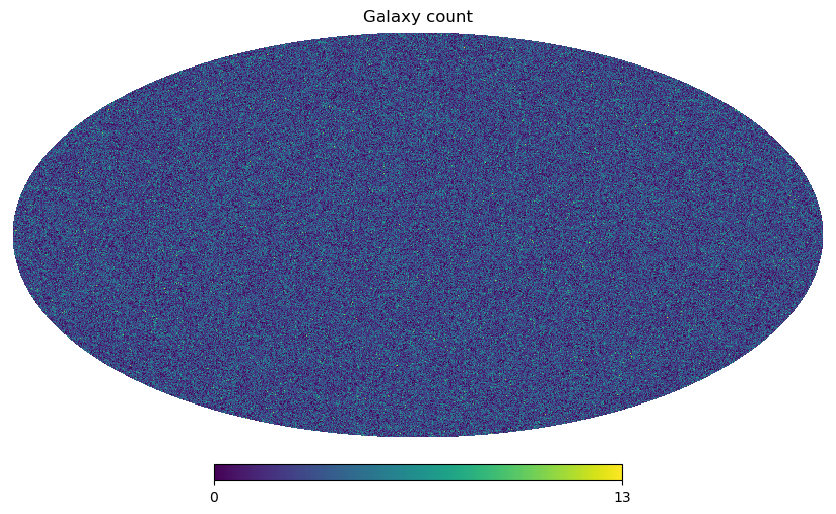

In [7]:
cat = fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1].data
nside = 512
npix = hp.nside2npix(nside)
ipix = hp.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True)
aaa=fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1]
#pprint.pp(aaa.header)
ncount = np.bincount(ipix, minlength=npix)
hp.mollview(ncount, title='Galaxy count')
print(len(cat['RA']))




# TreeCorr

In [8]:
from __future__ import print_function
import treecorr
import fitsio
import time
import pprint
import pandas as pd

In [9]:
cat = fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1].data
#nside = 256
#npix = hp.nside2npix(nside)
#ipix = hp.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True)
#ncount = np.bincount(ipix, minlength=npix)
#sources = ncount[ipix]
catalog_sources = treecorr.Catalog(ra=cat["RA"], dec=cat["DEC"], 
                          ra_units='deg', dec_units='deg')



DD_L = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
RR_L = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
DR_L = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
RD_L = treecorr.NNCorrelation(min_sep=0.5, max_sep=10, nbins=50, sep_units='degrees')
DD_L.process(catalog_sources)

n_pts_rand = int( 5 * len(cat["RA"]))

def _gen_random_catalogue_theta(RA_min, RA_max, DEC_min, DEC_max, Npoints, seed=None):
    # Code from Pedro Fanha
    # generates a region populated with Npoints random points
    # RA_min, RA_max, DEC_min, DEC_max are floats (limits of square region)
    # Npoints integer (number of points to generate in the random)
    # seed (optional, set it to generate a specific distribution of points)
    
    # https://math.stackexchange.com/questions/711594/uniform-sampling-from-part-of-sphere-surface
    # RA in [0, 360[, DEC in [-90, 90[

    # TO DO: are there any built in functions in scipy stats to do this (inverse CDF?)

    rng = np.random.default_rng(seed)

    # select u, v in region of angles that I want
    phi_min = RA_min/180*np.pi
    phi_max = RA_max/180*np.pi
    
    u_min = phi_min/(2*np.pi)
    u_max = phi_max/(2*np.pi)

    # calculations take phi -> ra (0 to 2pi) ==> u
    # and theta -> dec (0 to pi) ==> v + theta = 0 corresponds to z axis, declination starts at equator
    theta_min_2 = (90 - DEC_min)/180*np.pi
    theta_max_2 = (90 - DEC_max)/180*np.pi
    
    v_min = (np.cos(theta_min_2) + 1)/2
    v_max = (np.cos(theta_max_2) + 1)/2

    u = u_min + (u_max - u_min)*rng.uniform(0, 1, size=Npoints)
    v = v_min + (v_max - v_min)*rng.uniform(0, 1, size=Npoints)

    # transform from u, v to angles phi, theta and then to RA, DEC (convert to degree)
    ra = 2*np.pi*u
    ra_deg = ra/np.pi*180
    dec = np.pi/2 - np.arccos(2*v - 1)
    dec_deg = dec/np.pi*180

    return pd.DataFrame({'RA': ra_deg % 360, 'DEC': dec_deg})

df_sky_pos = _gen_random_catalogue_theta( RA_min=0, RA_max=360, DEC_min=-90, DEC_max=90, Npoints=n_pts_rand, seed=7+15*10 )
Rand = treecorr.Catalog(ra=df_sky_pos["RA"], dec=df_sky_pos["DEC"], ra_units='degrees', dec_units='degrees')
RR_L.process(Rand)
DR_L.process(catalog_sources, Rand)     # z bin 1
RD_L.process(Rand, catalog_sources)     # z bin 2

        # calculating values of clustering estimator, w(theta)
arr_xi_L, varxi_L  = DD_L.calculateXi(rr=RR_L, dr=DR_L, rd=RD_L)
arr_sig_L = np.sqrt(varxi_L)

r = np.exp(DD_L.meanlogr)
xi = arr_xi_L
varxi = varxi_L




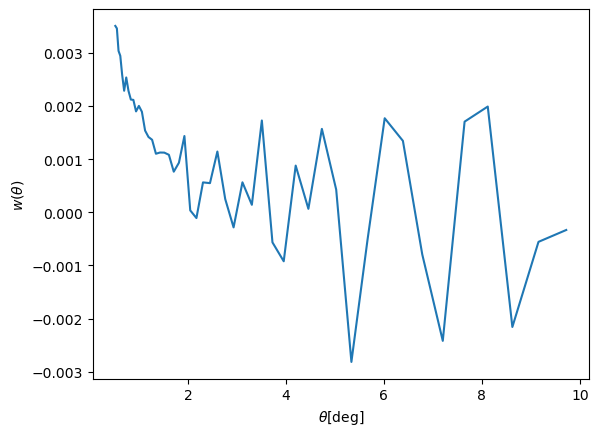

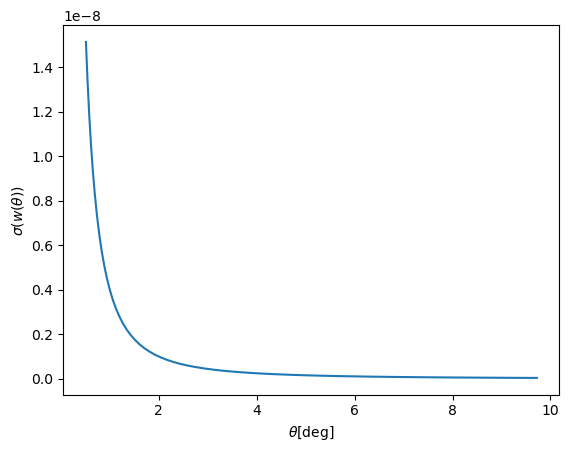

In [10]:
plt.plot(r, xi)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$w(\theta)$')
plt.show()

plt.plot(r, varxi)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$\sigma(w(\theta))$')
plt.show()

In [11]:
zs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49])

# CAMB

In [13]:
import camb
from camb import model
from camb.sources import SplinedSourceWindow

zs = np.arange(0.0, 1.0, 0.001)

# Get angular power spectrum for galaxy number counts and lensing
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2)
pars.InitPower.set_params(As=As, ns=ns)
lmax = 5000
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
pars.SourceWindows = [SplinedSourceWindow(z=zs, W=nz, bias_z=bz)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict(raw_cl=True)

# Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
# lensing window functions are for kappa (and counts for the fractional angular number density)
ls = np.arange(2, lmax + 1)
for spectrum in ["W1xW1", "PxW1", "PxP"]:
    plt.loglog(ls, cls[spectrum][2 : lmax + 1], label=spectrum)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.legend()

ValueError: Redshifts must be well sampled and in ascending order, with window function the same length as z

# CCL

In [ ]:
n_den=len(cat['RA'])/(4*np.pi)
print(1/n_den)

In [ ]:
import pyccl as ccl

ell, C_ell = ls, cls['W1xW1'][2 : lmax + 1]

#theta = np.logspace(-2, 1, 100)  # 0.01 to 10 degrees
theta = np.arange(0.1, 10, 0.05)  # 0.01 to 10 degrees


wtheta = ccl.correlation(cosmo, ell=ell, C_ell=C_ell, 
                         theta=theta, type='NN', method='FFTLog')

plt.figure(figsize=(10, 6))
plt.loglog(theta, wtheta, 'b-', linewidth=2)

plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function Comparison', fontsize=16)
plt.show()

In [ ]:
plt.plot(r, xi,'o',ls='',label='CoLoRe')
plt.plot(theta, wtheta, 'b-', linewidth=2,)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$w(\theta)$')
plt.yscale('log')
plt.show()
